# Smart Engineer
This notebook is a part of competitions organised by hackerearth. The goal of the competition is to predict net electricity generated given ambient variables.

In [41]:
import pandas as pd
import numpy as np
import os
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression, Ridge, Lasso,RidgeCV, LassoCV
from sklearn.metrics import mean_squared_error,make_scorer
from sklearn.model_selection import GridSearchCV, KFold,train_test_split
from sklearn.preprocessing import StandardScaler,PolynomialFeatures
from sklearn.pipeline import make_pipeline


In [42]:
### settings of seaborn plots
import warnings
warnings.simplefilter('ignore')
%matplotlib inline
sns.set(style="ticks")
%config InlineBackend.figure_format = 'svg'

In [43]:
path = "/home/rahul/Documents/Rahul/Projects/Smart-Engineer/Electricity_Production"
train_path = os.path.join(path, "train_data.csv")
test_path = os.path.join(path, "test_data.csv")
data = pd.read_csv(train_path)
test = pd.read_csv(test_path)
print("The shape of the data frame is {}".format(data.shape))

The shape of the data frame is (2000, 5)


In [44]:
data.head()

T       V      P     RH        E
0  273.39  420.12  91.84  57.41  1778.12
1  195.26  248.88  92.29  35.21  1824.16
2  377.52  360.42  92.31  27.69  1761.72
3  171.60  244.98  91.61  56.99  1889.64
4  222.56  353.70  92.43  54.25  1806.68

In [45]:
data.describe()

T            V            P           RH            E
count  2000.000000  2000.000000  2000.000000  2000.000000  2000.000000
mean    256.010820   325.217580    92.111935    44.169640  1817.052860
std      95.188288    76.288073     0.539140     8.773132    66.594563
min      47.190000   152.160000    90.260000    15.530000  1700.560000
25%     175.695000   250.680000    91.730000    37.997500  1758.960000
50%     266.565000   307.800000    92.080000    45.160000  1808.400000
75%     334.880000   398.700000    92.482500    51.152500  1871.620000
max     455.390000   481.080000    93.890000    60.090000  1976.960000

In [46]:

sns.pairplot(data,size=1.5)
plt.show()

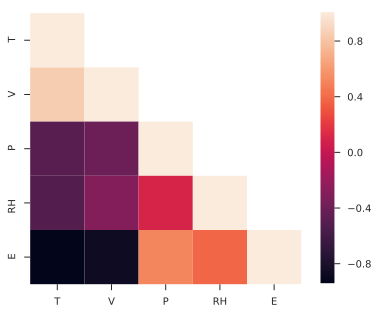

In [47]:
####  Generating a correlation matrix plot #####
corr = data.corr()
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask, k=1)] = True

f, ax = plt.subplots(figsize=(7, 5))
sns.heatmap(corr, mask=mask, square=True,robust = True, ax=ax)
plt.show()

Relative humidity and pressure are the least correlated variable with electricity generated. Temperature and exhaust vaccum are highly correlated variables with electricity generated. They will be most useful in linear regression models.

In [48]:
data['index'] = range(2000)
data['more_than_3q'] = data['E'] > 1871.620000
data['more_than_3q'] = data['more_than_3q'].apply(lambda x: int(x))
data['more_than_mean'] = data['E'] > data['E'].mean()
data['more_than_mean'] = data['more_than_mean'].apply(lambda x: int(x))

claasifying the pressure according to variable which is 1 when mean is greater than zero otherwise 0. Let's see if it could help in generating some new features. We think of it because pressure variable has low correlation with target variable. With some careful EDA, we could make it more useful in predicting the target variables.

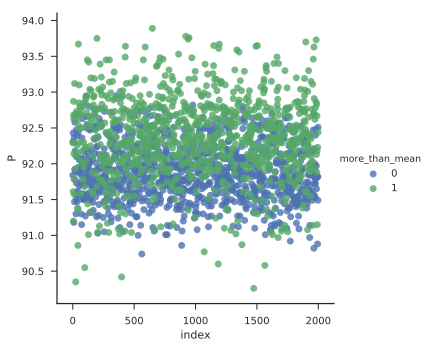

In [49]:
sns.lmplot(x='index',y='P',data=data,hue='more_than_mean', fit_reg=False)
plt.show()

**It's clear from the above graph that no meaningful feature could be generated with it.**

There is a sharp decline in binsize of exhaust variable. Lets explore it with density plot.

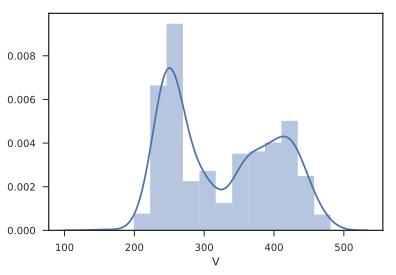

In [50]:
sns.distplot(data['V'])
sns.set(style = 'ticks')
plt.show()

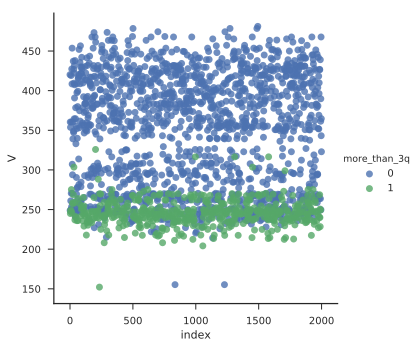

In [51]:
sns.lmplot('index', 'V', data = data, hue='more_than_3q', fit_reg=False)
plt.show()

We can generate a new feature based on above plot. It seems that exhaust pressure less than 300 Hg cm are always predicting the extreme target values.

In [52]:
data['V_3q'] = data['V'] > 300
test['V_3q'] = test['V'] > 300
data['V_3q'] = data['V_3q'].apply(lambda x: int(x))
test['V_3q'] = data['V_3q'].apply(lambda x: int(x))

Now we generate a new feature by deviding pressure with temperature, It could be useful because according to gas equation PV = nRT, P/T roughly is a measure of density of gas which could be an important variable in predicting the energy genrated.

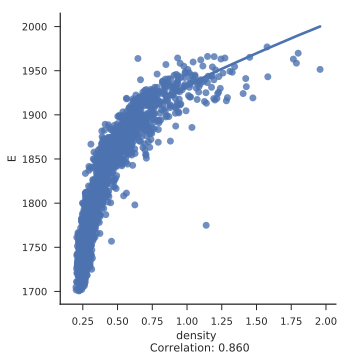

In [53]:
data['density'] = data['P']/data['T']
test['density'] = test['P']/test['T']
sns.lmplot('density', 'E', data=data, lowess=True)

plt.xlabel("density \n Correlation: {:.3f}".format(np.corrcoef(data['density'], data['E'])[0,1]))
plt.show()

**It turns out that this could be very useful feature in predicting the target variable.** We can replace pressure with this variable.

Generating a new feature based on the exhaust pressure (V) and normal pressure by taking difference of them. 

In [54]:
data['V_'] = data['V'].apply(lambda x: x*13.3322387) ## converting cm Hg to milibars
test['V_'] = test['V'].apply(lambda x: x*13.3322387)

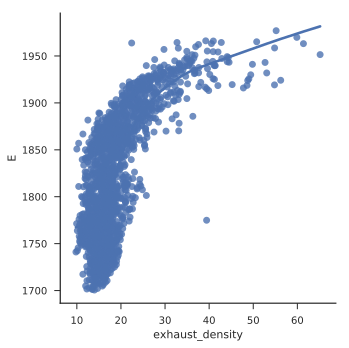

In [55]:
data['exhaust_density'] = data['V_']/data['T']
test['exhaust_density'] = test['V_']/test['T']
sns.lmplot('exhaust_density', 'E', data=data, lowess=True)
plt.show()

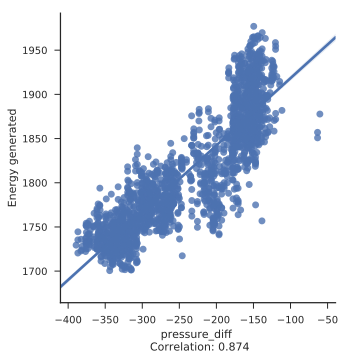

In [56]:
data['pressure_diff'] = (data['P'] - data['V'])
sns.lmplot('pressure_diff', 'E', data=data)
plt.xlabel('pressure_diff \n Correlation: {:.3f}'.format(np.corrcoef(data['pressure_diff'],
                                                                    data['E'])[0,1]))
plt.ylabel("Energy generated")
plt.show()

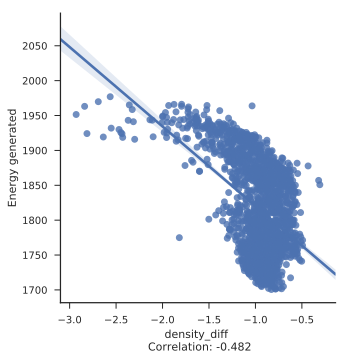

In [57]:
data['density_diff'] = data['pressure_diff']/data['T']
sns.lmplot('density_diff', 'E', data=data)
plt.xlabel('density_diff \n Correlation: {:.3f}'.format(np.corrcoef(data['density_diff'],
                                                                    data['E'])[0,1]))
plt.ylabel("Energy generated")
plt.show()

**Final data preparation for training**

In [18]:
data.head()

T       V      P     RH        E  index  more_than_3q  more_than_mean  \
0  273.39  420.12  91.84  57.41  1778.12      0             0               0   
1  195.26  248.88  92.29  35.21  1824.16      1             0               1   
2  377.52  360.42  92.31  27.69  1761.72      2             0               0   
3  171.60  244.98  91.61  56.99  1889.64      3             1               1   
4  222.56  353.70  92.43  54.25  1806.68      4             0               0   

   V_3q   density           V_  exhaust_density  pressure_diff  density_diff  
0     1  0.335930  5601.140123        20.487729        -328.28     -1.200775  
1     0  0.472652  3318.127568        16.993381        -156.59     -0.801956  
2     1  0.244517  4805.205472        12.728347        -268.11     -0.710188  
3     0  0.533858  3266.131837        19.033402        -153.37     -0.893765  
4     1  0.415304  4715.612828        21.188052        -261.27     -1.173931

In [58]:
train = data.drop(['index', 'more_than_3q','more_than_mean','V_'], axis=1)
target = data['E']
features_to_standarize = ['T','V','P','RH','pressure_diff','density']
train.head()

T       V      P     RH        E  V_3q   density  exhaust_density  \
0  273.39  420.12  91.84  57.41  1778.12     1  0.335930        20.487729   
1  195.26  248.88  92.29  35.21  1824.16     0  0.472652        16.993381   
2  377.52  360.42  92.31  27.69  1761.72     1  0.244517        12.728347   
3  171.60  244.98  91.61  56.99  1889.64     0  0.533858        19.033402   
4  222.56  353.70  92.43  54.25  1806.68     1  0.415304        21.188052   

   pressure_diff  density_diff  
0        -328.28     -1.200775  
1        -156.59     -0.801956  
2        -268.11     -0.710188  
3        -153.37     -0.893765  
4        -261.27     -1.173931

Now we have generated some new features based on our data exploration, let's try to visualize correlation between them, so that the assumption of linear regression (features are uncorrelated) can be checked. We will use heat map to visualize them.

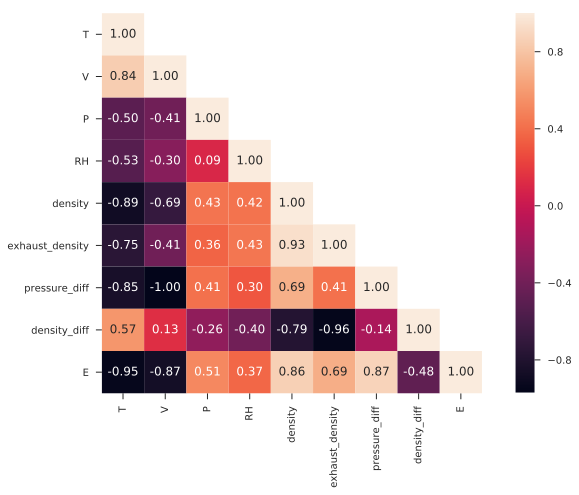

In [59]:
numeric_features = ['T','V','P','RH','density','exhaust_density','pressure_diff','density_diff','E']
corr = data[numeric_features].corr()
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask, k=1)] = True

f, ax = plt.subplots(figsize=(12, 7))
sns.heatmap(corr, mask=mask,annot=True,fmt='.2f', square=True,robust = True, ax=ax)

plt.show()

We can remove some of the features based on the heatmap for linear regression problems. Most of the features we have generated are highly correlated among others, so they could be problematic in our regression settings. Neverthless, they could be useful in other tree based models. From all the other features generated, we will only **density_diff** in our final features for regression model.

# Modeling#
  

**We started with ploynomial regression then move on more advanced techniques like RandomForest and boosting algorithm.**
The scatter plot between density and target variable suggest that it could be modeled well with a polynomial regression.

In [60]:
def standarize(xtrain,xtest):
    scaler = StandardScaler()
    scaler.fit(xtrain)
    xtrain = scaler.transform(xtrain)
    xtest = scaler.transform(xtest)
    return xtrain, xtest

In [61]:
def rmse(ytrue,ypred):
    error = mean_squared_error(ytrue,ypred)
    return np.sqrt(error)

## Polynomial Regression

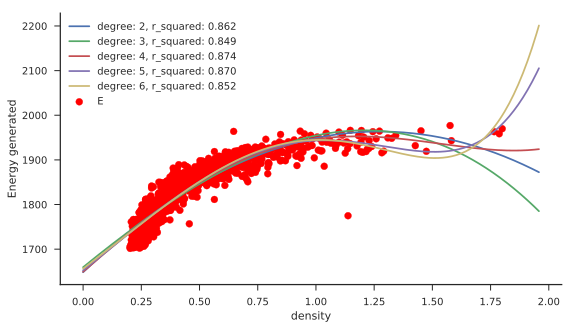

In [62]:
### Fitting a 2 degree polynomial with l2 regularization.
Xtrain = train['density']
Ytrain = target
xtrain,xval,ytrain,yval = train_test_split(Xtrain,Ytrain,test_size=0.3)
degrees = [2,3,4,5,6]
x_plot = np.linspace(0, max(Xtrain), 200)  ### for generating the polynomial plot
fig, ax = plt.subplots(figsize=(9,5))
ax.scatter(xtrain,ytrain,c='red')
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
for degree in degrees:
    model = make_pipeline(PolynomialFeatures(degree), Ridge())
    model.fit(xtrain.reshape(-1,1),ytrain.reshape(-1,1))
    score = model.score(xval.reshape(-1,1),yval)
    y_plot = model.predict(x_plot.reshape(-1,1))
    
    
    ax.plot(x_plot,y_plot,label="degree: {}, r_squared: {:.3f}".format(degree,score))
plt.xlabel('density')
plt.ylabel('Energy generated')
plt.legend()
plt.show()

Our newly generated feature **density** is able to capture much more than 86% of the variance in our data. From the above graph the polynomial with degree 6 performs best on the test data set.

Now we will fit the linear regression model on with selected features. 

##  Ridge regression

In [66]:
#### Fitting a multiple linear regression model with selected features.
features_for_regression = ['T','V','P','RH','V_3q','exhaust_density']
Xtrain = train[features_for_regression]
Ytrain = target
xtrain,xval,ytrain,yval = train_test_split(Xtrain,Ytrain,test_size=0.3)
xtrain,xval  = standarize(xtrain,xval)

lr_model = Ridge()
lr_model.fit(xtrain,ytrain)

lr_pred = lr_model.predict(xval)
r_squared = lr_model.score(xval,yval)
print("The r_squared of our model is {} and rmse is {}".format(r_squared, rmse(yval,lr_pred)))

The r_squared of our model is 0.9284863886016985 and rmse is 17.942651490029327


In [69]:
#### Tunning our model's parameter with the GridSearch ########
alphas = np.linspace(1,50,100)
n_splits=4
param_grid = {'alpha':alphas}
scaler = StandardScaler()
Xtrain_standarize = scaler.fit_transform(Xtrain)
scorer = make_scorer(mean_squared_error,greater_is_better=False)

grid_search = GridSearchCV(Ridge(), param_grid=param_grid,cv=3,scoring=scorer)
grid_search.fit(Xtrain_standarize,Ytrain)

best_alpha = grid_search.best_params_['alpha']
best_cv_score = np.sqrt(abs(grid_search.best_score_))
train_score = np.sqrt(abs(grid_search.score(Xtrain_standarize,Ytrain)))

print("The best l2-regularization parameter for the model is {:.3f}".format(best_alpha))
print("The rmse score on the training data is {}".format(train_score)) 
print("The rmse score on the cross validated data is {}".format(best_cv_score))

The best l2-regularization parameter for the model is 1.000
The rmse score on the training data is 17.505614755147224
The rmse score on the cross validated data is 17.548505897802883


In [72]:
###### Making predictions on the test data with our tuned model 
xtest = scaler.transform(test[features_for_regression])
final_prediction1 = Ridge(alpha=11.189).fit(Xtrain,Ytrain).predict(xtest)